In [1]:
# Sequential Frame Prediction using Cross-Modal Attention
# Dataset: StoryReasoning from HuggingFace
# Model: CNN + LSTM + Attention Mechanism

"""
Project: Comic Strip Frame Prediction
Student Project - Deep Learning Course
Dataset: Kaggle Comic Books (via HuggingFace StoryReasoning)
Model Architecture: Convolutional Neural Network + LSTM + Cross-Modal Attention
"""

'\nProject: Comic Strip Frame Prediction\nStudent Project - Deep Learning Course\nDataset: Kaggle Comic Books (via HuggingFace StoryReasoning)\nModel Architecture: Convolutional Neural Network + LSTM + Cross-Modal Attention\n'

In [2]:
# Cell 1: Load Dataset
import torch
from datasets import load_dataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset with streaming
print("Loading dataset...")
dataset = load_dataset("daniel3303/StoryReasoning", streaming=True)
print("Dataset loaded successfully")
print(f"Device: {device}")

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Dataset loaded successfully
Device: cpu


In [3]:
# Cell 2: Dataset Class with Text Processing

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import BertTokenizer
import re
import random

# Initialize BERT tokenizer for text processing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_size = tokenizer.vocab_size

class StoryDataset(Dataset):
    def __init__(self, hf_dataset, sequence_length=3, transform=None, max_stories=800):
        self.sequence_length = sequence_length
        self.transform = transform
        self.tokenizer = tokenizer
        self.sequences = []

        story_count = 0
        for story in hf_dataset:
            if story_count >= max_stories:
                break

            num_frames = len(story['images'])
            if num_frames >= sequence_length + 1:
                for i in range(num_frames - sequence_length):
                    self.sequences.append({
                        'story_data': story,
                        'start_idx': i
                    })

            story_count += 1

        print(f"Created {len(self.sequences)} sequences from {story_count} stories")

    def extract_text(self, grounded_story):
        """Extract clean text from grounded story XML tags"""
        if not grounded_story:
            return ""
        clean_text = re.sub(r'<[^>]+>', '', grounded_story)
        return clean_text.strip()

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq_info = self.sequences[idx]
        story = seq_info['story_data']
        start_idx = seq_info['start_idx']

        # Load input frames
        input_frames = []
        for i in range(self.sequence_length):
            img = story['images'][start_idx + i]
            if self.transform:
                img = self.transform(img)
            input_frames.append(img)

        # Load target frame
        target_img = story['images'][start_idx + self.sequence_length]
        if self.transform:
            target_img = self.transform(target_img)

        # Extract narrative text
        narrative = self.extract_text(story.get('story', ''))

        # Tokenize narrative for input
        text_encoding = self.tokenizer(
            narrative[:512],  # Limit text length
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Extract caption for target frame
        caption_text = narrative[:200] if narrative else "A comic panel"
        caption_encoding = self.tokenizer(
            caption_text,
            max_length=50,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_images': torch.stack(input_frames),
            'target_image': target_img,
            'text_tokens': text_encoding['input_ids'].squeeze(0),
            'text_mask': text_encoding['attention_mask'].squeeze(0),
            'caption_tokens': caption_encoding['input_ids'].squeeze(0),
            'caption_mask': caption_encoding['attention_mask'].squeeze(0)
        }

# Define transforms with 256x256 size
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets
print("Loading train data subset...")
train_dataset = StoryDataset(dataset['train'], sequence_length=3, transform=transform, max_stories=800)

print("Loading val data subset...")
val_dataset = StoryDataset(dataset['train'], sequence_length=3, transform=transform, max_stories=200)

print("Loading test data subset...")
test_dataset = StoryDataset(dataset['test'], sequence_length=3, transform=transform, max_stories=100)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=2)

print("Dataloaders created successfully")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading train data subset...
Created 7678 sequences from 800 stories
Loading val data subset...
Created 1942 sequences from 200 stories
Loading test data subset...
Created 1002 sequences from 100 stories
Dataloaders created successfully


In [4]:
# Cell 3: Model Architecture with U-Net + ResNet + Perceptual Loss
import torch
import torch.nn as nn
import torchvision.models as models

# Pretrained ResNet Encoder with skip connections
class ResNetEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super(ResNetEncoder, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, output_dim)

    def forward(self, x):
        # Store skip connections
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        skip1 = x

        x = self.maxpool(x)
        x = self.layer1(x)
        skip2 = x

        x = self.layer2(x)
        skip3 = x

        x = self.layer3(x)
        skip4 = x

        x = self.layer4(x)


        # Global feature
        features = self.avgpool(x)
        features = features.view(features.size(0), -1)
        features = self.fc(features)

        return features, [skip1, skip2, skip3, skip4]

# U-Net Style Decoder with skip connections
class UNetDecoder(nn.Module):
    def __init__(self, input_dim=512):
        super(UNetDecoder, self).__init__()

        # Initial projection from feature vector
        self.fc = nn.Linear(input_dim, 512 * 4 * 4)

        # Upsampling layers
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.up6 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)
        self.final = nn.Tanh()

    def forward(self, x, skip_connections):
        skip1, skip2, skip3, skip4 = skip_connections

        # Reshape to spatial
        x = self.fc(x)
        x = x.view(x.size(0), 512, 4, 4)

        # Decoder with skip connections - with proper spatial matching
        x = self.up1(x)

        skip4_resized = torch.nn.functional.interpolate(skip4, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip4_resized], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        skip3_resized = torch.nn.functional.interpolate(skip3, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip3_resized], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        skip2_resized = torch.nn.functional.interpolate(skip2, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip2_resized], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        skip1_resized = torch.nn.functional.interpolate(skip1, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip1_resized], dim=1)
        x = self.conv4(x)

        x = self.up5(x)
        x = self.up6(x)
        x = self.final(x)

        return x

# LSTM Sequence Encoder
class SequenceEncoder(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=512, num_layers=2):
        super(SequenceEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        return hidden[-1]

# Attention Module
class AttentionModule(nn.Module):
    def __init__(self, feature_dim=512):
        super(AttentionModule, self).__init__()
        self.query = nn.Linear(feature_dim, feature_dim)
        self.key = nn.Linear(feature_dim, feature_dim)
        self.value = nn.Linear(feature_dim, feature_dim)
        self.scale = feature_dim ** 0.5

    def forward(self, visual_features, sequence_features):
        Q = self.query(visual_features).unsqueeze(1)
        K = self.key(sequence_features).unsqueeze(1)
        V = self.value(sequence_features).unsqueeze(1)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attended_features = torch.matmul(attention_weights, V).squeeze(1)
        fused_features = visual_features + attended_features

        return fused_features, attention_weights

# Perceptual Loss using VGG16
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features
        self.slice1 = nn.Sequential(*list(vgg)[:4])
        self.slice2 = nn.Sequential(*list(vgg)[4:9])
        self.slice3 = nn.Sequential(*list(vgg)[9:16])
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, pred, target):
        pred_feats1 = self.slice1(pred)
        target_feats1 = self.slice1(target)
        pred_feats2 = self.slice2(pred_feats1)
        target_feats2 = self.slice2(target_feats1)
        pred_feats3 = self.slice3(pred_feats2)
        target_feats3 = self.slice3(target_feats2)

        loss = torch.mean((pred_feats1 - target_feats1)**2) + \
               torch.mean((pred_feats2 - target_feats2)**2) + \
               torch.mean((pred_feats3 - target_feats3)**2)
        return loss

# Combined loss
class EnhancedMultimodalLoss(nn.Module):
    def __init__(self):
        super(EnhancedMultimodalLoss, self).__init__()
        self.perceptual = PerceptualLoss()
        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()

    def forward(self, predicted_image, target_image, attention_weights):
        # Image reconstruction loss
        l1_loss = self.l1(predicted_image, target_image)
        mse_loss = self.mse(predicted_image, target_image)
        perceptual_loss = self.perceptual(predicted_image, target_image)

        # Attention entropy
        attention_entropy = -torch.mean(attention_weights * torch.log(attention_weights + 1e-8))

        # Combined loss
        total_loss = l1_loss + 0.1 * perceptual_loss + 0.05 * attention_entropy
        return total_loss

# Main Frame Predictor
class FramePredictor(nn.Module):
    def __init__(self):
        super(FramePredictor, self).__init__()
        self.image_encoder = ResNetEncoder(output_dim=512)
        self.sequence_encoder = SequenceEncoder(input_dim=512, hidden_dim=512)
        self.attention = AttentionModule(feature_dim=512)
        self.decoder = UNetDecoder(input_dim=512)

    def forward(self, input_sequence):
        batch_size, seq_len = input_sequence.size(0), input_sequence.size(1)

        image_features = []
        for t in range(seq_len):
            features, skip_connections = self.image_encoder(input_sequence[:, t])
            image_features.append(features)
            if t == seq_len - 1:

                decoder_skips = skip_connections

        # Stack features
        image_features = torch.stack(image_features, dim=1)

        # Encode sequence
        sequence_features = self.sequence_encoder(image_features)

        # Gets last frame visual features
        last_image_features = image_features[:, -1]

        # Apply attention
        fused_features, attention_weights = self.attention(last_image_features, sequence_features)

        # Decode with skip connections
        predicted_image = self.decoder(fused_features, decoder_skips)

        return predicted_image, attention_weights

# Initialize model
model = FramePredictor().to(device)
criterion = EnhancedMultimodalLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:13<00:00, 41.2MB/s]


Total parameters: 25,004,243
Trainable parameters: 25,004,243


In [5]:
# Text Encoder, Caption Decoder, and Cross-Modal Components

from transformers import BertModel

class CrossModalAttention(nn.Module):
    def __init__(self, feature_dim=512):
        super().__init__()
        self.query_visual = nn.Linear(feature_dim, feature_dim)
        self.key_visual = nn.Linear(feature_dim, feature_dim)
        self.value_visual = nn.Linear(feature_dim, feature_dim)
        self.key_text = nn.Linear(feature_dim, feature_dim)
        self.value_text = nn.Linear(feature_dim, feature_dim)
        self.scale = feature_dim ** 0.5

    def forward(self, visual_features, text_features, sequence_features):
        Q = self.query_visual(visual_features).unsqueeze(1)
        K_seq = self.key_visual(sequence_features).unsqueeze(1)
        V_seq = self.value_visual(sequence_features).unsqueeze(1)
        K_txt = self.key_text(text_features).unsqueeze(1)
        V_txt = self.value_text(text_features).unsqueeze(1)
        K = torch.cat([K_seq, K_txt], dim=1)
        V = torch.cat([V_seq, V_txt], dim=1)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attended_features = torch.matmul(attention_weights, V).squeeze(1)
        fused_features = visual_features + attended_features
        return fused_features, attention_weights

class TextEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        self.projection = nn.Sequential(
            nn.Linear(768, output_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        projected = self.projection(pooled)
        return projected

class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, fused_features, target_captions):
        batch_size = fused_features.size(0)
        max_len = target_captions.size(1)
        h0 = fused_features.unsqueeze(0).repeat(2, 1, 1)
        c0 = torch.zeros_like(h0)
        input_token = torch.full((batch_size, 1), 101, dtype=torch.long, device=fused_features.device)
        outputs = []
        hidden = (h0, c0)
        for t in range(max_len):
            embedded = self.embedding(input_token)
            lstm_out, hidden = self.lstm(embedded, hidden)
            logits = self.fc(lstm_out)
            outputs.append(logits)
            if random.random() < 0.5 and t < max_len - 1:
                input_token = target_captions[:, t+1].unsqueeze(1)
            else:
                input_token = logits.argmax(dim=-1)
        outputs = torch.cat(outputs, dim=1)
        return outputs

class EnhancedFramePredictor(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.image_encoder = ResNetEncoder(output_dim=512)
        self.text_encoder = TextEncoder(output_dim=512)
        self.sequence_encoder = SequenceEncoder(input_dim=512, hidden_dim=512)
        self.attention = CrossModalAttention(feature_dim=512)
        self.decoder = UNetDecoder(input_dim=512)
        self.caption_decoder = CaptionDecoder(vocab_size=vocab_size)

    def forward(self, input_sequence, text_tokens, text_mask, caption_tokens=None):
        batch_size, seq_len = input_sequence.size(0), input_sequence.size(1)
        image_features = []
        for t in range(seq_len):
            features, skip_connections = self.image_encoder(input_sequence[:, t])
            image_features.append(features)
            if t == seq_len - 1:
                decoder_skips = skip_connections
        image_features = torch.stack(image_features, dim=1)
        text_features = self.text_encoder(text_tokens, text_mask)
        sequence_features = self.sequence_encoder(image_features)
        last_image_features = image_features[:, -1]
        fused_features, attention_weights = self.attention(
            last_image_features, text_features, sequence_features
        )
        predicted_image = self.decoder(fused_features, decoder_skips)
        if caption_tokens is not None:
            caption_logits = self.caption_decoder(fused_features, caption_tokens)
            return predicted_image, caption_logits, attention_weights
        return predicted_image, None, attention_weights

model = EnhancedFramePredictor(vocab_size=vocab_size).to(device)
criterion = EnhancedMultimodalLoss().to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 170,893,069
Trainable parameters: 61,410,829


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

save_dir = '/content/drive/MyDrive'

model = EnhancedFramePredictor(vocab_size=vocab_size).to(device)
criterion = EnhancedMultimodalLoss().to(device)

state_dict = torch.load(f'{save_dir}/model_best_multimodal.pth',
                        map_location=device)
model.load_state_dict(state_dict)
model.eval()
train_losses = [0.0]
val_losses = [0.0]

Mounted at /content/drive


In [ ]:
# Cell 4: Resume Training from Epoch 10

import os
from google.colab import drive
from tqdm import tqdm
import torch
import torch.nn.functional as F

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

save_dir = '/content/drive/MyDrive'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


start_epoch = 10
num_epochs = 20
checkpoint_path = f'{save_dir}/model_epoch_10.pth'

# Recreate model, loss, optimizer
model = EnhancedFramePredictor(vocab_size=vocab_size).to(device)
criterion = EnhancedMultimodalLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Load epoch-10 epochs
if os.path.exists(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)
else:
    start_epoch = 0


def train_epoch(model, dataloader, criterion, optimizer, device, vocab_size):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(dataloader, desc='Training')

    for batch in pbar:
        input_images = batch['input_images'].to(device)
        target_image = batch['target_image'].to(device)
        text_tokens = batch['text_tokens'].to(device)
        text_mask = batch['text_mask'].to(device)
        caption_tokens = batch['caption_tokens'].to(device)

        optimizer.zero_grad()

        predicted_image, caption_logits, attention_weights = model(
            input_images, text_tokens, text_mask, caption_tokens
        )

        image_loss = criterion(predicted_image, target_image, attention_weights)
        caption_loss = F.cross_entropy(
            caption_logits.reshape(-1, vocab_size),
            caption_tokens.reshape(-1),
            ignore_index=0
        )

        loss = image_loss + 0.5 * caption_loss
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return epoch_loss / len(dataloader)


def validate(model, dataloader, criterion, device, vocab_size):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_images = batch['input_images'].to(device)
            target_image = batch['target_image'].to(device)
            text_tokens = batch['text_tokens'].to(device)
            text_mask = batch['text_mask'].to(device)
            caption_tokens = batch['caption_tokens'].to(device)

            predicted_image, caption_logits, attention_weights = model(
                input_images, text_tokens, text_mask, caption_tokens
            )

            image_loss = criterion(predicted_image, target_image, attention_weights)
            caption_loss = F.cross_entropy(
                caption_logits.reshape(-1, vocab_size),
                caption_tokens.reshape(-1),
                ignore_index=0
            )

            loss = image_loss + 0.5 * caption_loss
            val_loss += loss.item()

    return val_loss / len(dataloader)


train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, vocab_size)
    val_loss = validate(model, val_loader, criterion, device, vocab_size)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{save_dir}/model_best_multimodal.pth')

    # Save checkpoint every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f'{save_dir}/model_epoch_{epoch+1}.pth')

# Final save at the end of training
torch.save(model.state_dict(), f'{save_dir}/model_final_multimodal.pth')

Mounted at /content/drive

Epoch 11/20


Training: 100%|██████████| 3839/3839 [19:20<00:00,  3.31it/s, loss=1.6791]



Epoch 12/20


Training: 100%|██████████| 3839/3839 [19:18<00:00,  3.31it/s, loss=1.4275]



Epoch 13/20


Training: 100%|██████████| 3839/3839 [19:16<00:00,  3.32it/s, loss=1.7058]



Epoch 14/20


Training: 100%|██████████| 3839/3839 [19:18<00:00,  3.31it/s, loss=1.5227]



Epoch 15/20


Training: 100%|██████████| 3839/3839 [19:16<00:00,  3.32it/s, loss=1.9970]



Epoch 16/20


Training: 100%|██████████| 3839/3839 [19:21<00:00,  3.30it/s, loss=1.8283]



Epoch 17/20


Training: 100%|██████████| 3839/3839 [19:17<00:00,  3.32it/s, loss=0.9697]



Epoch 18/20


Training: 100%|██████████| 3839/3839 [19:21<00:00,  3.31it/s, loss=2.0261]



Epoch 19/20


Training: 100%|██████████| 3839/3839 [19:19<00:00,  3.31it/s, loss=1.2595]



Epoch 20/20


Training: 100%|██████████| 3839/3839 [19:25<00:00,  3.29it/s, loss=1.4808]


Evaluating model on test set...

Test Loss: 0.6217
Final Train Loss: 0.0000
Final Val Loss: 0.0000


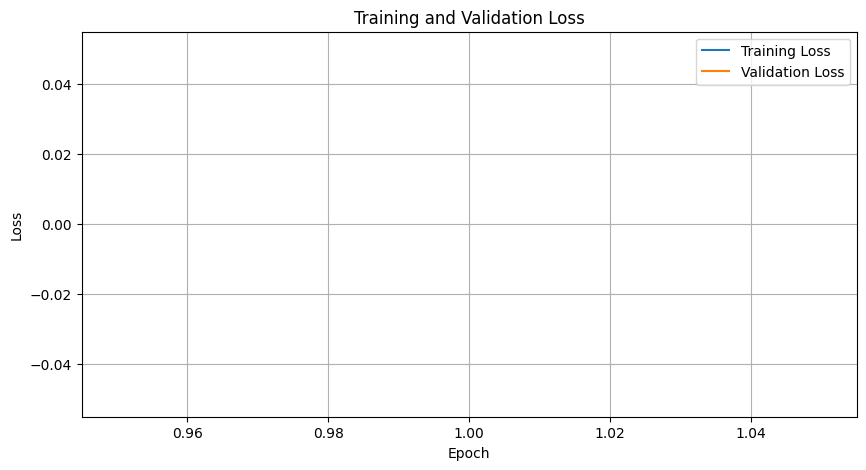


Evaluation complete


In [8]:
# Cell 5: Evaluation and Training Loss Plot
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load best model
model = EnhancedFramePredictor(vocab_size=vocab_size).to(device)
state = torch.load('/content/drive/MyDrive/model_best_multimodal.pth',
                   map_location=device)
model.load_state_dict(state)
model.eval()

print("Evaluating model on test set...")

# Compute test loss on up to 20 batches
test_loss = 0.0
num_batches = 0

with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        if batch_idx >= 20:
            break

        input_images = batch['input_images'].to(device)
        target_images = batch['target_image'].to(device)
        text_tokens = batch['text_tokens'].to(device)
        text_mask = batch['text_mask'].to(device)
        caption_tokens = batch['caption_tokens'].to(device)

        predicted_images, caption_logits, attention_weights = model(
            input_images, text_tokens, text_mask, caption_tokens
        )
        loss = criterion(predicted_images, target_images, attention_weights)
        test_loss += loss.item()
        num_batches += 1

test_loss = test_loss / max(1, num_batches)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")

# Plot training curves from current run (20 epochs)
num_epochs = len(train_losses)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

print("\nEvaluation complete")

Generating prediction...


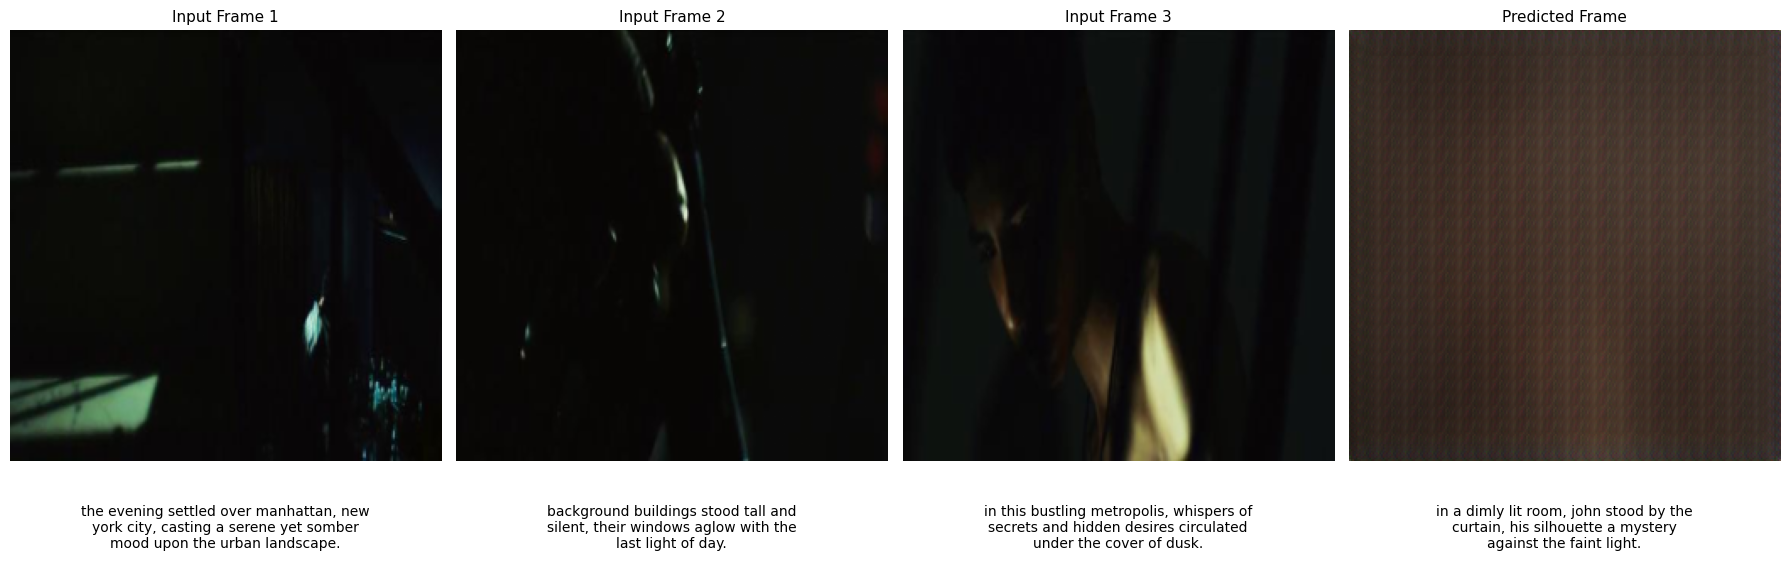


Prediction complete


In [9]:
# Cell 6: Frame Prediction with Random Story Selection
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
from transformers import BertTokenizer
import textwrap

print("Generating prediction...")

model.eval()

# Select random batch
random_skip = random.randint(0, 50)
test_iter = iter(test_loader)
for _ in range(random_skip):
    try:
        batch = next(test_iter)
    except:
        test_iter = iter(test_loader)
        batch = next(test_iter)
        break

input_images = batch['input_images'][0:1].to(device)
target_image = batch['target_image'][0:1].to(device)

# Model prediction
with torch.no_grad():
    text_tokens = batch['text_tokens'][0:1].to(device)
    text_mask = batch['text_mask'][0:1].to(device)
    predicted_image, _, _ = model(input_images, text_tokens, text_mask)

# Image enhancement
def enhance(img):
    img = (img + 1) / 2
    img = img * 2.5
    img = torch.clamp(img, 0, 1)
    img = (img * 2) - 1
    return img

predicted_image = enhance(predicted_image[0])

# Denormalization
def denorm(img):
    return torch.clamp((img + 1) / 2, 0, 1)

input_seq = [denorm(input_images[0][i]).cpu() for i in range(3)]
predicted = denorm(predicted_image).cpu()

# Decode captions
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_tokens_np = batch['text_tokens'][0].cpu().numpy()
full_text = tokenizer.decode(text_tokens_np, skip_special_tokens=True)

sentences = [s.strip() + '.' for s in full_text.split('.') if s.strip()]

if len(sentences) >= 4:
    caps = sentences[:4]
else:
    caps = sentences + [f"Frame {i+1}" for i in range(len(sentences), 4)]

# ---- SIDE BY SIDE DISPLAY ----
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

all_images = input_seq + [predicted]
titles = ["Input Frame 1", "Input Frame 2", "Input Frame 3", "Predicted Frame"]

for idx, ax in enumerate(axes):
    img = all_images[idx].permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(titles[idx], fontsize=11)

    # Wrap caption text so it stays inside width
    wrapped_caption = "\n".join(textwrap.wrap(caps[idx], width=40))
    ax.text(
        0.5, -0.10,
        wrapped_caption,
        transform=ax.transAxes,
        ha="center",
        va="top",
        fontsize=10
    )

plt.tight_layout()
plt.show()

print("\nPrediction complete")